<a href="https://colab.research.google.com/github/LucasLessa1/X-rayBodyPart/blob/davi1/Proj_CIS_Imagens_Raio_X.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports and Ajusting file


Proj_CIS_Imagens_Raio_X.ipynb

In [308]:
pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [309]:
import cv2
import pydicom
import pandas as pd
import os
import shutil
import time
import math
import gdown
import zipfile
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import os
from PIL import Image
import string
import glob

In [310]:
from numpy import expand_dims
import tensorflow as tf
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
import random, time

In [311]:
def download(id): 
    url = 'https://drive.google.com/uc?id=' + str(id)
    gdown.download(url, output = None, quiet = False)

def unzip(path): #Função para unzip
    zip = zipfile.ZipFile(path)
    zip.extractall()
    zip.close()

In [312]:
# https://drive.google.com/file/d/1ev-r31j8oRzDlKM_toaeADO2psrA_XXm/view?usp=sharing

download('1ev-r31j8oRzDlKM_toaeADO2psrA_XXm')
unzip('/content/archive.zip')

Downloading...
From: https://drive.google.com/uc?id=1ev-r31j8oRzDlKM_toaeADO2psrA_XXm
To: /content/archive.zip
100%|██████████| 269M/269M [00:01<00:00, 233MB/s]


In [313]:
#os.chdir("/content/drive/MyDrive/RAIO-X/RAIO-X/archive.zip (Unzipped Files)")
path = os.getcwd() 
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv(os.path.join('/content/sample_submission.csv'))

In [314]:
test_df.head(5)

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10001001190452685542...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
1,1.2.826.0.1.3680043.8.498.10022667601042710442...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
2,1.2.826.0.1.3680043.8.498.10024395388921105474...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
3,1.2.826.0.1.3680043.8.498.10026689165626095651...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
4,1.2.826.0.1.3680043.8.498.10035936364561920980...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...


#Pre-processing

In [315]:
print("Columns:")
print(train_df.columns, "\n")

print("Types in columns:")
print(train_df.dtypes, "\n")

print("Types in info:")
print(train_df.describe(), "\n")

Columns:
Index(['SOPInstanceUID', 'Target'], dtype='object') 

Types in columns:
SOPInstanceUID    object
Target            object
dtype: object 

Types in info:
                                           SOPInstanceUID Target
count                                                1738   1738
unique                                               1738     41
top     1.2.826.0.1.3680043.8.498.10025629581362719970...     3 
freq                                                    1    724 



In [316]:
#Let's  see our Target distribution

bodyparts = {
0 : 'Abdomen' ,
1 :'Ankle' ,
2 :'Cervical Spine',
3 : 'Chest' ,
4 :'Clavicles' ,
5 :'Elbow' ,
6 :'Feet' ,
7 : 'Finger' ,
8 : 'Forearm' ,
9 : 'Hand' ,
10 : 'Hip' ,
11 : 'Knee' ,
12 : 'Lower Leg' ,
13 : 'Lumbar Spine' ,
14 : 'Others' ,
15 :'Pelvis',
16 :'Shoulder' ,
17 :'Sinus' ,
18 : 'Skull' ,
19 : 'Thigh' ,
20 :'Thoracic Spine',
21: 'Wrist',
}

##Fixing folders

In [317]:
info = []

In [318]:

class Image_processing():
  def __init__(self, folder, newFolder):
    self.fileList = []
    self.rotationRange = 90 
    self.brightRange = [0.2, 1.5]
    self.folder = folder #This is the folder of the original folder image
    self.newFolder = newFolder #This is the new folder


  def createfolders(self):
    os.mkdir(f'/content/{self.newFolder}/') 
    #os.chdir(f'/content/{self.newFolder}') 
    for bodypart in list(bodyparts.values()):
      if os.path.isdir(f'/content/{self.newFolder}/{bodypart}') == False:
        os.mkdir(f'/content/{self.newFolder}/{bodypart}')
      else:  
          pass       

  def folderImagebyLabel(self, df, dictionary):
    filelist = []
    for root, dirs, files in os.walk(f'/content/{str(self.folder)}'):
      for file in files:
        filelist.append(os.path.join(root,file))

    for filename in filelist:
      dicom = pydicom.dcmread(filename)
      img = dicom.pixel_array
      var = filename.split("/")
      var = var[-1]
      row = df.index[df['SOPInstanceUID']==f'{var[:-6]}'].tolist()
      target = df['Target'].iloc[row[0]]
      if len(target.strip()) > 2: 
        continue
      label = dictionary.get(int(target))
      resized_img  = (np.maximum(img,0)/img.max())*255 
      im = resized_img.astype(np.uint8)
      # Chama classe CLAHE(equaliador de brilho) -argumentos: valor máximo para limitação do contraste(evitar predominancia de sinal ruim), tamanho dos grides de divisão de imagem para se aplicar o processo
      clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
      # Aplica no canal que importa- a luminosidade
      clahe_img = clahe.apply(im)
      im = Image.fromarray(clahe_img)
      im.show()
      im.save(os.path.join(f'/content/{self.newFolder}', f'{label}', f'{var[:-6]}.png'))

  def allImagesFolder(self, df):
    filelist = []
    for root, dirs, files in os.walk(f'/content/{str(self.folder)}'):
      for file in files:
        filelist.append(os.path.join(root,file))

    for filename in filelist:
      dicom = pydicom.dcmread(filename)
      img = dicom.pixel_array
      var = filename.split("/")
      var = var[-1]
      row = df.index[df['SOPInstanceUID']==f'{var[:-6]}'].tolist()
      resized_img  = (np.maximum(img,0)/img.max())*255 
      im = resized_img.astype(np.uint8)
      # Chama classe CLAHE(equaliador de brilho) -argumentos: valor máximo para limitação do contraste(evitar predominancia de sinal ruim), tamanho dos grides de divisão de imagem para se aplicar o processo
      clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
      # Aplica no canal que importa- a luminosidade
      clahe_img = clahe.apply(im)
      im = Image.fromarray(clahe_img)
      im.show()
      im.save(os.path.join(f'/content/{self.newFolder}/', f'{var[:-6]}.png'))


 

In [319]:
#Organize the test images folder
# 856vbnm
nameFolderTest = "test_img"
processImageTest = Image_processing(folder='test', newFolder = nameFolderTest)

try:
  os.mkdir(f'/content/{nameFolderTest}')
  processImageTest.allImagesFolder(train_df)

except:
  shutil.rmtree(f'/content/{nameFolderTest}/')
  os.mkdir(f'/content/{nameFolderTest}')
  processImageTest.allImagesFolder(train_df)


In [320]:
# for files in os.listdir('/content/test_img'):
#   print(files)
#   print(len(os.listdir(f'/content/test_img/{files}')))

In [321]:
#Organize the train images folder
nameFolderTrain = "train_img"
processImageTrain = Image_processing(folder='train', newFolder = nameFolderTrain)

try:
  processImageTrain.createfolders()
  #This "train" is the name of the original folder of the images
  processImageTrain.folderImagebyLabel(train_df, bodyparts)
except:
  shutil.rmtree(f'/content/{nameFolderTrain}/')
  processImageTrain.createfolders()
  processImageTrain.folderImagebyLabel(train_df, bodyparts)


In [322]:
class Data_Augumentation(Image_processing):

  def __init__(self, folder, newFolder, folder_img):
    super().__init__(folder, newFolder)
    # Image_processing.__init__(self, folder, newFolder)
    self.folder_img = folder_img

  def process_imgs(self, qntd = 100):
    for folder in os.listdir(f'/content/{self.folder_img}'):
      real_qntd = len(os.listdir(f'/content/{self.folder_img}/{folder}'))
      # print(real_qntd)
      if real_qntd < qntd: 
        diff = len(os.listdir(f'/content/{self.folder_img}/{folder}')) 
        if diff >= 50 :
          exams = random.choices(os.listdir(f'/content/{self.folder_img}/{folder}'), k= (qntd - diff))
          self.augment(folder, exams, 1)
        else:
          if diff % 10 != 0: #Se não for multiplo de 10
            #Quantos algarismos para próxima dezena
            ref1 = (math.ceil(diff / 10) * 10) - diff  
            for _ in range(ref1):
              exams = random.choices(os.listdir(f'/content/{self.folder_img}/{folder}'), k= ref1)
              self.augment(folder, exams, 1)
          ref2 = qntd - (math.ceil(diff / 10) * 10)
          #pego 10 de amsmostra e multiplico a quantidade de vezes para somar 100 
          for _ in range(ref2):
            exams = random.choices(os.listdir(f'/content/{self.folder_img}/{folder}'), k= 10)
            ref2 = int(ref2/10)
            self.augment(folder, exams, ref2)
      elif real_qntd > qntd:
        diff = (real_qntd-qntd)
        sorteados = glob.glob(f'/content/{self.folder_img}/{folder}/*')
        for s in random.sample(sorteados, diff):
          os.remove(s)


  def augment(self, folder, exams, limit):
    #folder = nome que eu dei para pasta da label (ex : skull)
    #exams  = lista de arquivos de imagens para cara pasta de label 
    #limit = quantidade de imagens artificias criadas a partir da original
    
    nameImage = []
    cont1 = -1
    for exam in exams: 
      #Saving the name in the list
      nameImage.append(exam)
      # load the image
      img = load_img(f'/content/{self.folder_img}/{folder}/{exam}')
      # convert to numpy array
      data = img_to_array(img)
      # expand dimension to one sample
      samples = expand_dims(data, 0)
      # create image data augmentation generator
      datagen = ImageDataGenerator(horizontal_flip=True,rotation_range = self.rotationRange, brightness_range = self.brightRange)
      # prepare iterator
      it = datagen.flow(samples, batch_size=1)
      cont1 =+ 1
      dup = [x for i, x in enumerate(nameImage) if i != nameImage.index(x)]

      if len(dup) > 0:
        equalDup = "_repeted_" + str(random.randint(-9999,9999))
      else:
        equalDup = ""
        
      for cont in range(limit):
        # generate batch of images
        batch = it.next()
        image = batch[0].astype('uint16')
        resized_img  = (np.maximum(image,0)/image.max())*255 
        im = Image.fromarray(resized_img.astype(np.uint8))
        rand = random.randint(-9999,9999)
        info.append(f'/content/{self.folder_img}/{folder}/{exam[:-4]}_copy_{cont1}_{cont}.png')
        im.save(f'/content/{self.folder_img}/{folder}/{exam[:-4]}_{equalDup}_copy_{cont1}_{cont}.png')


In [323]:
#Augumented for Train image
AugumentedTrain  =  Data_Augumentation(folder='train', newFolder = nameFolderTrain, folder_img = "train_img")
AugumentedTrain.process_imgs()

# #Augumented for Train image
# AugumentedTest  =  Data_Augumentation(folder='test', newFolder = nameFolderTest, folder_img = "test_img")
# AugumentedTest.process_imgs()

In [324]:
class SelectFolders():

  def __init__(self, mainPath, root, qntd):
    self.mainPath = mainPath
    self.qntdImages = qntd
    self.listNames = []
    self.flag = []
    self.rootPath = root
  
  def verify(self, folder2verify ,order):
    for files in os.listdir(folder2verify):
      self.listNames.append([files, len(os.listdir(f'{folder2verify}/{files}')) ])
      #Verify listNames

    for i in self.listNames:
      if i[1] > self.qntdImages:
        #False se tiver pastas com menos de 100 imagens ou menos que self.qntdImages
        self.flag.append([False, i[0], i[1]])

    if order == "print":
      print(self.flag)
    if order =="result":
      flagzinha = False
      for i in zip(self.flag):
        if i[0] ==True:
          print(f"Error: The folder {i[1]} has {i[2]} Images.")
        else:
          flagzinha = True

      if flagzinha == True: 
        print(f"Every folder has more than {self.qntdImages} Images.")

  def folder2Model(self, path, qntd , bodyparts): 
    try:
      os.mkdir(f"{self.rootPath}/{path}")
      print(self.rootPath)
      print(path)
    except:
      shutil.rmtree(f"{self.rootPath}/{path}")
      os.mkdir(f"{self.rootPath}/{path}")


    for part in list(bodyparts.values()):
      if os.path.isdir(f"{self.rootPath}/{path}/{part}") == False:
        os.mkdir(f"{self.rootPath}/{path}/{part}")
      #Seleciona 100 imagens de "part" e copio para imageModel
      selectImages = random.choices(os.listdir(f'{self.mainPath}/{part}'), k= qntd)

      for image in selectImages:
        pathImageModel = f"{self.rootPath}/{path}/{part}"
        originalPathImages = f'{self.mainPath}/{part}/{image}'
        # print(originalPathImages)

        shutil.copy(originalPathImages, pathImageModel)


In [325]:
fix2 = SelectFolders("/content/train_img", "/content" ,  100)
path = "imageModel/"
#Verify if train_img has more than 100 images 
fix2.verify( "/content/train_img" ,"result")

#Organizing the folder for the model
fix2.folder2Model(path, 100, bodyparts)

#Verify if imageModel has 100 images for each folder 
print()
fix2.verify("/content/imageModel" ,"result")

Every folder has more than 100 Images.

Every folder has more than 100 Images.


# Model

In [326]:
#Setting the size of images for the template
batch_size = 32
img_height = 180 
img_width = 180

data_dir = "/content/train_img"

In [327]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2387 files belonging to 22 classes.
Using 1910 files for training.


In [328]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2387 files belonging to 22 classes.
Using 477 files for validation.


## Extra

In [329]:
class_names = train_ds.class_names
# print(class_names)

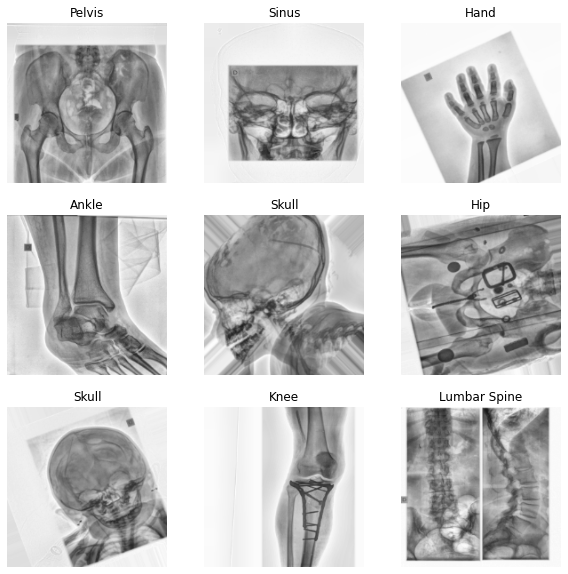

In [330]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [331]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## Implementing Model